In [1]:
CSV_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

In [2]:
import pickle
import pandas as pd
import numpy as np
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

In [3]:
results_df = pickle.load(open(CSV_PATH  + 'results_df.pickle', 'rb'))

In [4]:
#results_df = results_df.iloc[0:1000000]

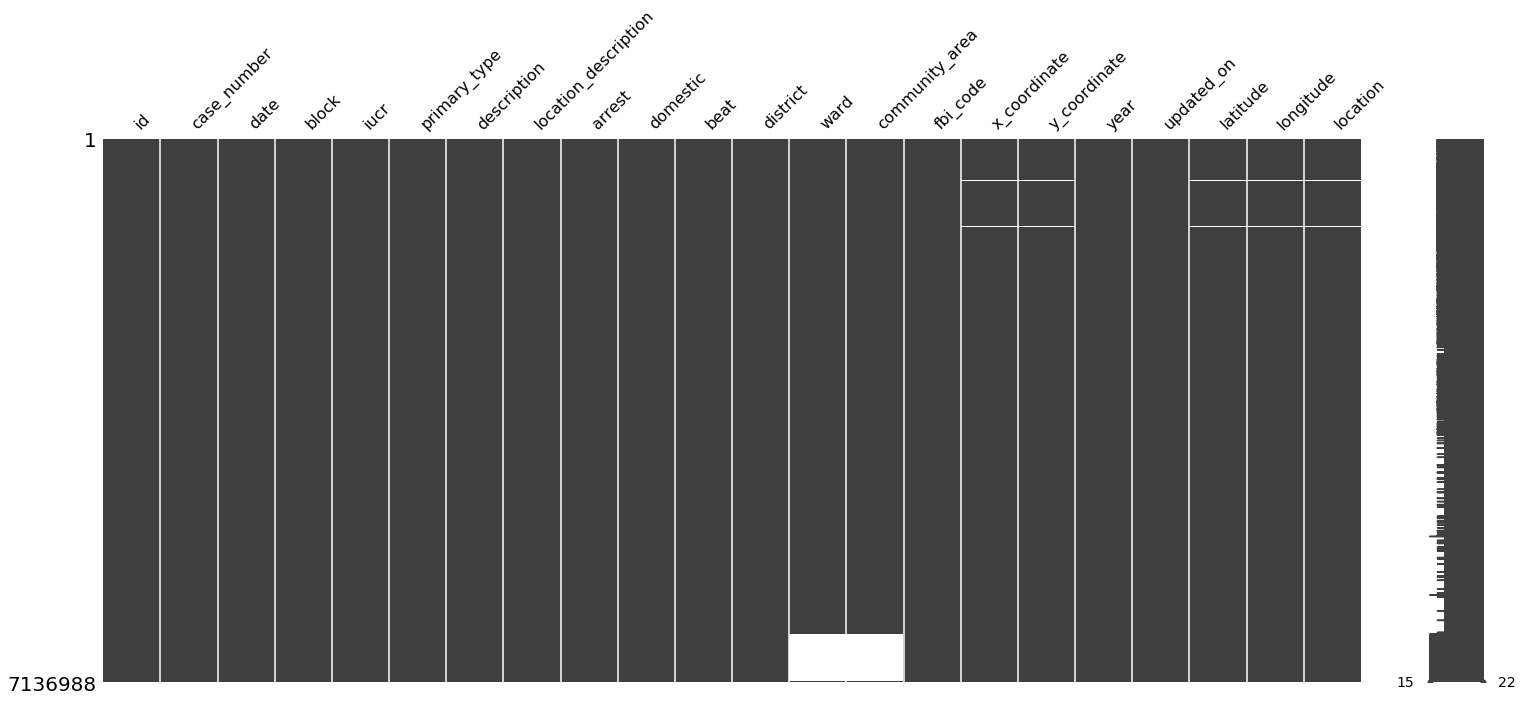

In [5]:
#plot missing variables list
import matplotlib.pyplot as plt
import missingno as msno
msno.matrix(results_df)
plt.show()

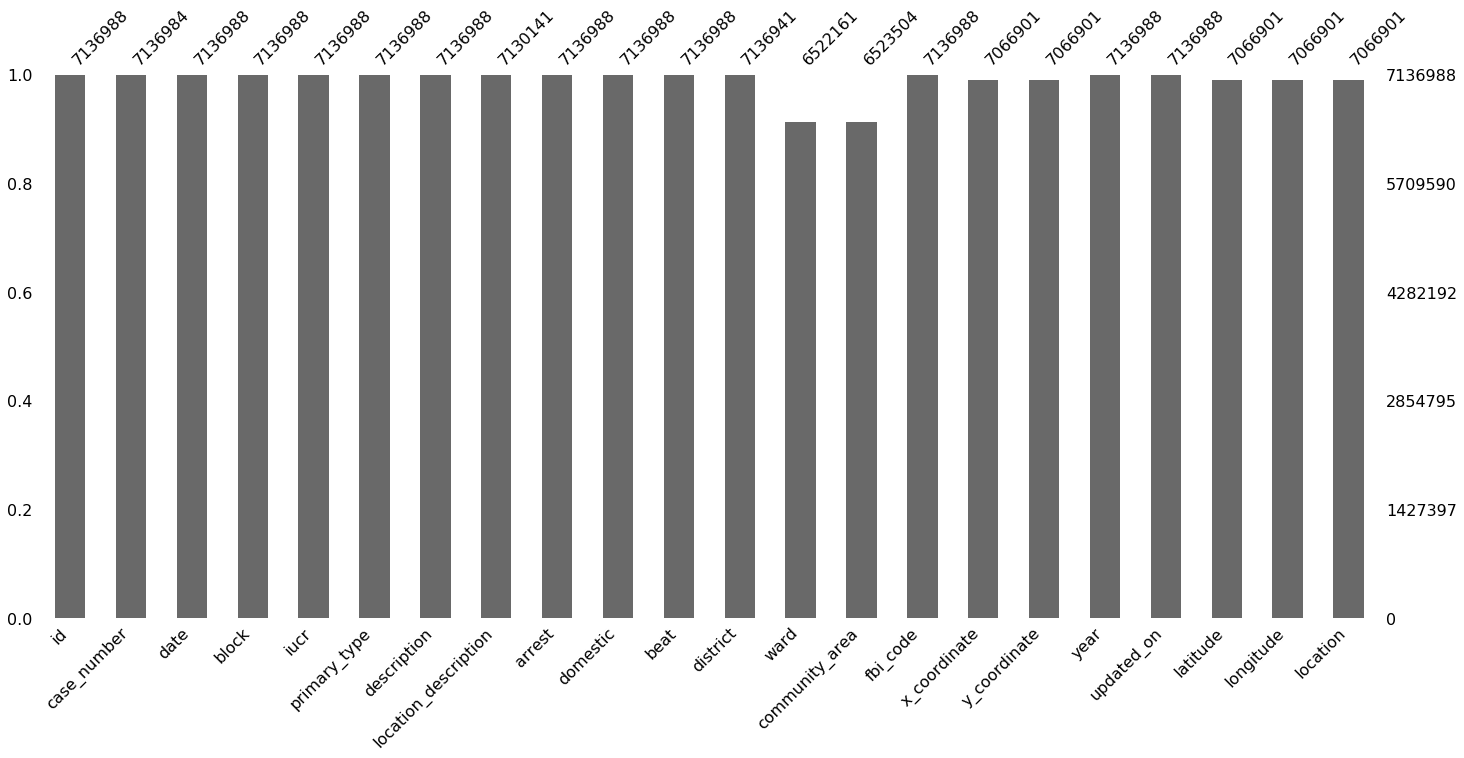

In [6]:
msno.bar(results_df) 

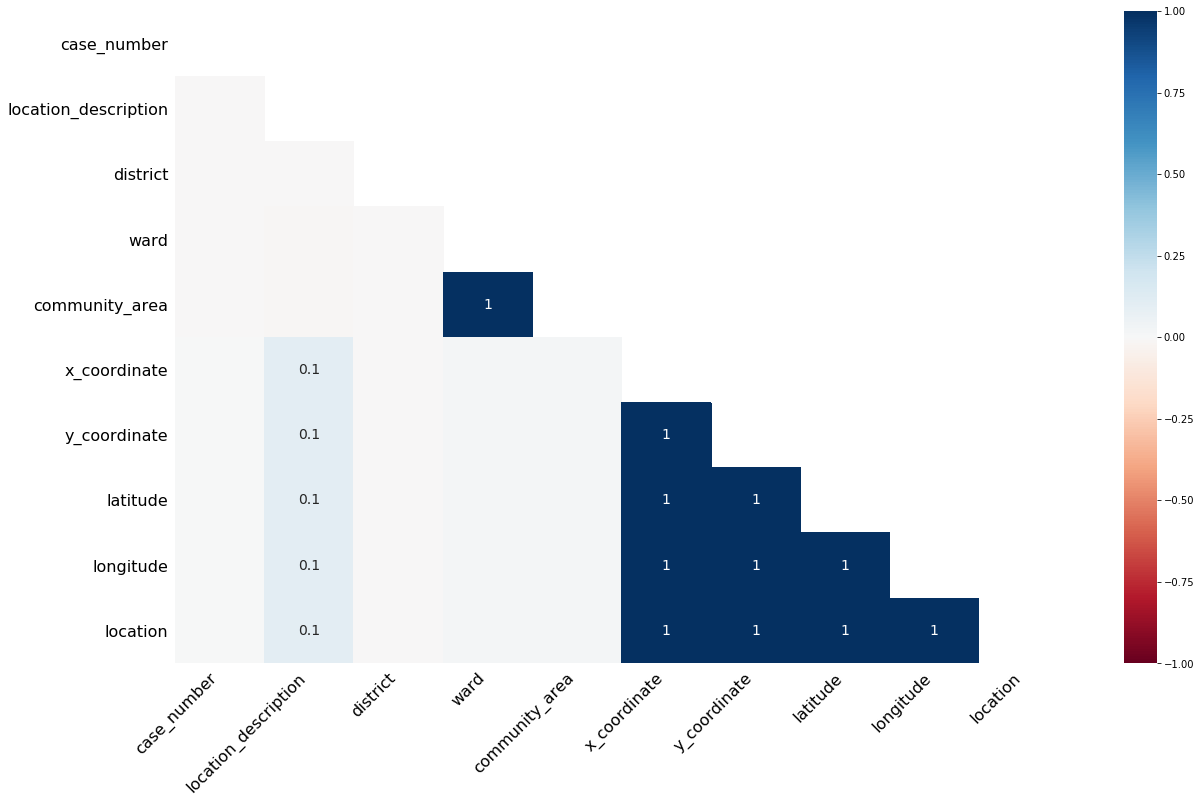

In [7]:
msno.heatmap(results_df) 

In [8]:
results_df.primary_type.value_counts()

THEFT                                1508340
BATTERY                              1306042
CRIMINAL DAMAGE                       812210
NARCOTICS                             731312
ASSAULT                               449266
OTHER OFFENSE                         443339
BURGLARY                              403274
MOTOR VEHICLE THEFT                   328306
DECEPTIVE PRACTICE                    292360
ROBBERY                               268040
CRIMINAL TRESPASS                     203172
WEAPONS VIOLATION                      80823
PROSTITUTION                           69207
PUBLIC PEACE VIOLATION                 50195
OFFENSE INVOLVING CHILDREN             49203
CRIM SEXUAL ASSAULT                    28572
SEX OFFENSE                            27137
INTERFERENCE WITH PUBLIC OFFICER       17230
GAMBLING                               14580
LIQUOR LAW VIOLATION                   14366
ARSON                                  11810
HOMICIDE                               10319
KIDNAPPING

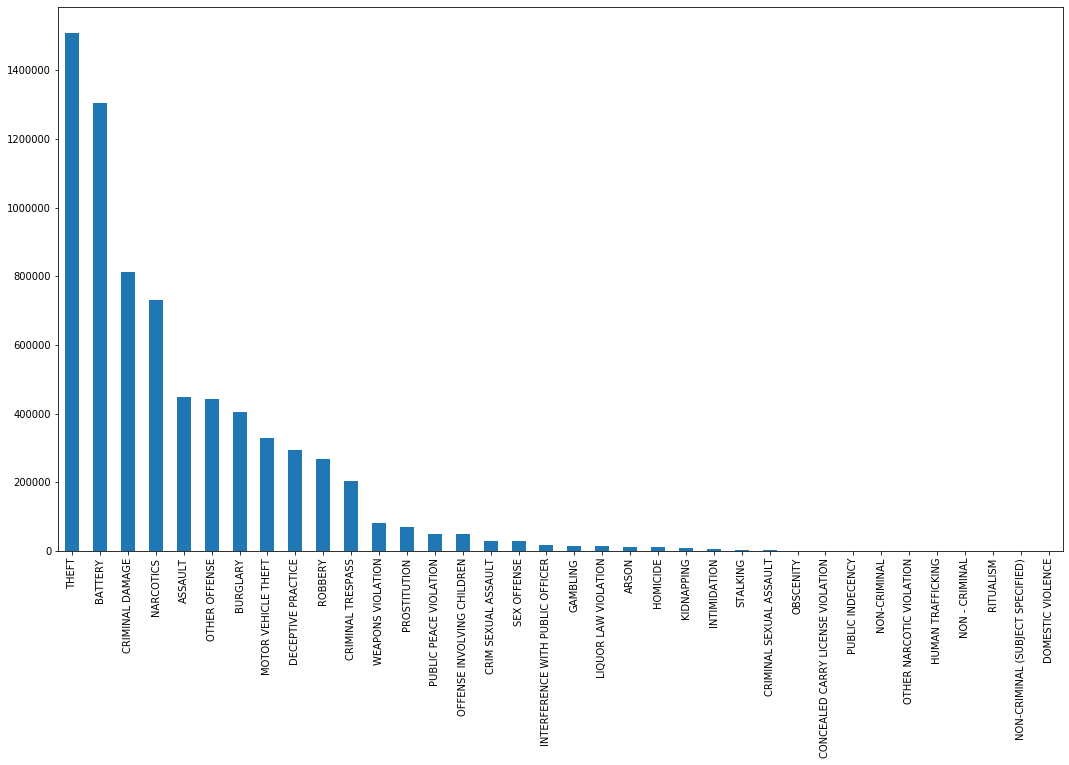

In [9]:
results_df.primary_type.value_counts().plot.bar(figsize=(18,10))

In [10]:
print(max(results_df.date))
print(min(results_df.date))

2020-06-12T23:40:00.000
2001-01-01T00:00:00.000


#### Chicago City Bound

In [11]:
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)

In [12]:
test_df = results_df
test_df = test_df[test_df.latitude.notna()].sort_values(['date'], ascending=[0])
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['updated_on'] = pd.to_datetime(test_df['updated_on'])
test_df['latitude'] = pd.to_numeric(test_df['latitude'])
test_df['longitude'] = pd.to_numeric(test_df['longitude'])

df = test_df
df.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [13]:
print(max(test_df['latitude']))
print(min(test_df['latitude']))
print(max(test_df['longitude']))
print(min(test_df['longitude']))

42.022910333
36.619446395
-87.524529378
-91.686565684


In [14]:
print(max(test_df['date']))
print(min(test_df['date']))

2020-06-12 23:40:00
2001-01-01 00:00:00


In [15]:
 df.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [16]:
map_arr = []
interval_int = 30 #use 30 days data to predict next 7 days
series_range = 7 #days
time_interval = timedelta(days=interval_int)
date_start = min(df['date'])
date_end = max(df['date'])

geo_price_map = df[['date', 'primary_type','latitude', 'longitude']]

"""geo_price_map = df[['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location']]"""

"geo_price_map = df[['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',\n       'description', 'location_description', 'arrest', 'domestic', 'beat',\n       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',\n       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',\n       'location']]"

In [17]:
filter1a = pd.to_numeric(geo_price_map['longitude']) > xbound[0]
filter1b = pd.to_numeric(geo_price_map['longitude']) < xbound[1]
filter1c = pd.to_numeric(geo_price_map['latitude']) > ybound[0]
filter1d = pd.to_numeric(geo_price_map['latitude']) < ybound[1]
print("sum of remaining is: " + str(sum(filter1a&filter1b&filter1c&filter1d)))
geo_price_map = geo_price_map[filter1a&filter1b&filter1c&filter1d]

sum of remaining is: 7066583


In [18]:
print(max(geo_price_map['latitude']))
print(min(geo_price_map['latitude']))
print(max(geo_price_map['longitude']))
print(min(geo_price_map['longitude']))

42.022910333
41.644700444
-87.524529378
-87.934567226


In [18]:
#crime_2020_gdf = geo_price_map[geo_price_map.date > pd.to_datetime("2020-01-01")]

In [19]:
from scipy import stats as st
from scipy.stats import gaussian_kde as gaussian_kde
import numpy as np
from KDEpy import FFTKDE, NaiveKDE


def get_kde( x, y, xmin, xmax, ymin, ymax, xx, yy, positions):

    values = np.array([x, y]).T
    #values = values.reshape(values.shape[1], values.shape[0])
    #print("values is: " + str(values))
    #grid, points = get_kernel(values)
    points = get_kernel(values, positions)
    #kernel.set_bandwidth(bw_method=kernel.factor / 30.)
    f = np.reshape(points, xx.shape)
    #print(points.shape)
    #print(grid)
    #return grid, f
    return f

def get_kernel(data, positions):
    #print(data.shape)
    #print(data)
    estimator = FFTKDE(kernel='gaussian', norm=2, bw=0.001)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    points = estimator.fit(data, weights=None).evaluate(positions)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    #kernel = gaussian_kde(dataset=values, bw_method="silverman" )
    #return grid, points
    return points

In [22]:
grid_size = 25
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
positions = np.dstack([xx.ravel(), yy.ravel()])
positions = positions.reshape(positions.shape[1], positions.shape[2])
grid_matrix = positions

#### Group data by the windowed interval of 30 days, slide forward in increment of 7 days and aggregate windows into list of dataframes

In [23]:
for int_cur_date in range(0, (date_end - date_start).days - interval_int, int(series_range)):
#for int_start_date in range(365, 565, interval_int):
    geo_price_map_filtered = geo_price_map[geo_price_map['longitude'].notnull()]
    
    #filter2 = geo_price_map_filtered['REQUEST_DATE'] > (date_start + timedelta(days=int_start_date))
    #filter3 = geo_price_map_filtered['REQUEST_DATE'] <= (date_start + timedelta(days=int_start_date+interval_int))
    
    filter2 = geo_price_map_filtered['date'] > (date_end - timedelta(days=int_cur_date+interval_int))
    filter3 = geo_price_map_filtered['date'] <= (date_end -  timedelta(days=int_cur_date))
    
    print(date_end - timedelta(days=int_cur_date+interval_int))
    print(date_end -  timedelta(days=int_cur_date))
    
    
    geo_price_map_filtered = geo_price_map_filtered.where(filter2 & filter3)
    print("crime count: " + str(geo_price_map_filtered.notnull().sum()))
    df = geo_price_map_filtered
    points = get_kde(df["longitude"].dropna().to_numpy(), df["latitude"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
    density_matrix_t_series.append(points)
    print("_"*20)
    #map_arr.append(geo_price_map_filtered)

2020-05-13 23:40:00
2020-06-12 23:40:00
crime count: date            17034
primary_type    17034
latitude        17034
longitude       17034
dtype: int64
____________________
2020-05-06 23:40:00
2020-06-05 23:40:00
crime count: date            16743
primary_type    16743
latitude        16743
longitude       16743
dtype: int64
____________________
2020-04-29 23:40:00
2020-05-29 23:40:00
crime count: date            14467
primary_type    14467
latitude        14467
longitude       14467
dtype: int64
____________________
2020-04-22 23:40:00
2020-05-22 23:40:00
crime count: date            13500
primary_type    13500
latitude        13500
longitude       13500
dtype: int64
____________________
2020-04-15 23:40:00
2020-05-15 23:40:00
crime count: date            12984
primary_type    12984
latitude        12984
longitude       12984
dtype: int64
____________________
2020-04-08 23:40:00
2020-05-08 23:40:00
crime count: date            12488
primary_type    12488
latitude        12488
longit

2019-06-19 23:40:00
2019-07-19 23:40:00
crime count: date            23878
primary_type    23878
latitude        23878
longitude       23878
dtype: int64
____________________
2019-06-12 23:40:00
2019-07-12 23:40:00
crime count: date            23601
primary_type    23601
latitude        23601
longitude       23601
dtype: int64
____________________
2019-06-05 23:40:00
2019-07-05 23:40:00
crime count: date            23575
primary_type    23575
latitude        23575
longitude       23575
dtype: int64
____________________
2019-05-29 23:40:00
2019-06-28 23:40:00
crime count: date            23225
primary_type    23225
latitude        23225
longitude       23225
dtype: int64
____________________
2019-05-22 23:40:00
2019-06-21 23:40:00
crime count: date            23181
primary_type    23181
latitude        23181
longitude       23181
dtype: int64
____________________
2019-05-15 23:40:00
2019-06-14 23:40:00
crime count: date            23228
primary_type    23228
latitude        23228
longit

2018-07-25 23:40:00
2018-08-24 23:40:00
crime count: date            24081
primary_type    24081
latitude        24081
longitude       24081
dtype: int64
____________________
2018-07-18 23:40:00
2018-08-17 23:40:00
crime count: date            24221
primary_type    24221
latitude        24221
longitude       24221
dtype: int64
____________________
2018-07-11 23:40:00
2018-08-10 23:40:00
crime count: date            24026
primary_type    24026
latitude        24026
longitude       24026
dtype: int64
____________________
2018-07-04 23:40:00
2018-08-03 23:40:00
crime count: date            23998
primary_type    23998
latitude        23998
longitude       23998
dtype: int64
____________________
2018-06-27 23:40:00
2018-07-27 23:40:00
crime count: date            24089
primary_type    24089
latitude        24089
longitude       24089
dtype: int64
____________________
2018-06-20 23:40:00
2018-07-20 23:40:00
crime count: date            24047
primary_type    24047
latitude        24047
longit

2017-08-30 23:40:00
2017-09-29 23:40:00
crime count: date            22522
primary_type    22522
latitude        22522
longitude       22522
dtype: int64
____________________
2017-08-23 23:40:00
2017-09-22 23:40:00
crime count: date            22378
primary_type    22378
latitude        22378
longitude       22378
dtype: int64
____________________
2017-08-16 23:40:00
2017-09-15 23:40:00
crime count: date            22397
primary_type    22397
latitude        22397
longitude       22397
dtype: int64
____________________
2017-08-09 23:40:00
2017-09-08 23:40:00
crime count: date            22766
primary_type    22766
latitude        22766
longitude       22766
dtype: int64
____________________
2017-08-02 23:40:00
2017-09-01 23:40:00
crime count: date            23602
primary_type    23602
latitude        23602
longitude       23602
dtype: int64
____________________
2017-07-26 23:40:00
2017-08-25 23:40:00
crime count: date            24020
primary_type    24020
latitude        24020
longit

2016-10-05 23:40:00
2016-11-04 23:40:00
crime count: date            22879
primary_type    22879
latitude        22879
longitude       22879
dtype: int64
____________________
2016-09-28 23:40:00
2016-10-28 23:40:00
crime count: date            22542
primary_type    22542
latitude        22542
longitude       22542
dtype: int64
____________________
2016-09-21 23:40:00
2016-10-21 23:40:00
crime count: date            22698
primary_type    22698
latitude        22698
longitude       22698
dtype: int64
____________________
2016-09-14 23:40:00
2016-10-14 23:40:00
crime count: date            22782
primary_type    22782
latitude        22782
longitude       22782
dtype: int64
____________________
2016-09-07 23:40:00
2016-10-07 23:40:00
crime count: date            23244
primary_type    23244
latitude        23244
longitude       23244
dtype: int64
____________________
2016-08-31 23:40:00
2016-09-30 23:40:00
crime count: date            23475
primary_type    23475
latitude        23475
longit

2015-11-11 23:40:00
2015-12-11 23:40:00
crime count: date            19445
primary_type    19445
latitude        19445
longitude       19445
dtype: int64
____________________
2015-11-04 23:40:00
2015-12-04 23:40:00
crime count: date            19459
primary_type    19459
latitude        19459
longitude       19459
dtype: int64
____________________
2015-10-28 23:40:00
2015-11-27 23:40:00
crime count: date            20120
primary_type    20120
latitude        20120
longitude       20120
dtype: int64
____________________
2015-10-21 23:40:00
2015-11-20 23:40:00
crime count: date            21127
primary_type    21127
latitude        21127
longitude       21127
dtype: int64
____________________
2015-10-14 23:40:00
2015-11-13 23:40:00
crime count: date            21500
primary_type    21500
latitude        21500
longitude       21500
dtype: int64
____________________
2015-10-07 23:40:00
2015-11-06 23:40:00
crime count: date            21949
primary_type    21949
latitude        21949
longit

2014-12-17 23:40:00
2015-01-16 23:40:00
crime count: date            18716
primary_type    18716
latitude        18716
longitude       18716
dtype: int64
____________________
2014-12-10 23:40:00
2015-01-09 23:40:00
crime count: date            19064
primary_type    19064
latitude        19064
longitude       19064
dtype: int64
____________________
2014-12-03 23:40:00
2015-01-02 23:40:00
crime count: date            20244
primary_type    20244
latitude        20244
longitude       20244
dtype: int64
____________________
2014-11-26 23:40:00
2014-12-26 23:40:00
crime count: date            20119
primary_type    20119
latitude        20119
longitude       20119
dtype: int64
____________________
2014-11-19 23:40:00
2014-12-19 23:40:00
crime count: date            20481
primary_type    20481
latitude        20481
longitude       20481
dtype: int64
____________________
2014-11-12 23:40:00
2014-12-12 23:40:00
crime count: date            20156
primary_type    20156
latitude        20156
longit

2014-01-22 23:40:00
2014-02-21 23:40:00
crime count: date            19326
primary_type    19326
latitude        19326
longitude       19326
dtype: int64
____________________
2014-01-15 23:40:00
2014-02-14 23:40:00
crime count: date            19458
primary_type    19458
latitude        19458
longitude       19458
dtype: int64
____________________
2014-01-08 23:40:00
2014-02-07 23:40:00
crime count: date            19831
primary_type    19831
latitude        19831
longitude       19831
dtype: int64
____________________
2014-01-01 23:40:00
2014-01-31 23:40:00
crime count: date            18747
primary_type    18747
latitude        18747
longitude       18747
dtype: int64
____________________
2013-12-25 23:40:00
2014-01-24 23:40:00
crime count: date            19115
primary_type    19115
latitude        19115
longitude       19115
dtype: int64
____________________
2013-12-18 23:40:00
2014-01-17 23:40:00
crime count: date            19427
primary_type    19427
latitude        19427
longit

2013-02-27 23:40:00
2013-03-29 23:40:00
crime count: date            24061
primary_type    24061
latitude        24061
longitude       24061
dtype: int64
____________________
2013-02-20 23:40:00
2013-03-22 23:40:00
crime count: date            23640
primary_type    23640
latitude        23640
longitude       23640
dtype: int64
____________________
2013-02-13 23:40:00
2013-03-15 23:40:00
crime count: date            23411
primary_type    23411
latitude        23411
longitude       23411
dtype: int64
____________________
2013-02-06 23:40:00
2013-03-08 23:40:00
crime count: date            23204
primary_type    23204
latitude        23204
longitude       23204
dtype: int64
____________________
2013-01-30 23:40:00
2013-03-01 23:40:00
crime count: date            23084
primary_type    23084
latitude        23084
longitude       23084
dtype: int64
____________________
2013-01-23 23:40:00
2013-02-22 23:40:00
crime count: date            23524
primary_type    23524
latitude        23524
longit

2012-04-04 23:40:00
2012-05-04 23:40:00
crime count: date            27641
primary_type    27641
latitude        27641
longitude       27641
dtype: int64
____________________
2012-03-28 23:40:00
2012-04-27 23:40:00
crime count: date            27362
primary_type    27362
latitude        27362
longitude       27362
dtype: int64
____________________
2012-03-21 23:40:00
2012-04-20 23:40:00
crime count: date            27349
primary_type    27349
latitude        27349
longitude       27349
dtype: int64
____________________
2012-03-14 23:40:00
2012-04-13 23:40:00
crime count: date            27761
primary_type    27761
latitude        27761
longitude       27761
dtype: int64
____________________
2012-03-07 23:40:00
2012-04-06 23:40:00
crime count: date            27778
primary_type    27778
latitude        27778
longitude       27778
dtype: int64
____________________
2012-02-29 23:40:00
2012-03-30 23:40:00
crime count: date            27641
primary_type    27641
latitude        27641
longit

2011-05-11 23:40:00
2011-06-10 23:40:00
crime count: date            31107
primary_type    31107
latitude        31107
longitude       31107
dtype: int64
____________________
2011-05-04 23:40:00
2011-06-03 23:40:00
crime count: date            30912
primary_type    30912
latitude        30912
longitude       30912
dtype: int64
____________________
2011-04-27 23:40:00
2011-05-27 23:40:00
crime count: date            30531
primary_type    30531
latitude        30531
longitude       30531
dtype: int64
____________________
2011-04-20 23:40:00
2011-05-20 23:40:00
crime count: date            29988
primary_type    29988
latitude        29988
longitude       29988
dtype: int64
____________________
2011-04-13 23:40:00
2011-05-13 23:40:00
crime count: date            29458
primary_type    29458
latitude        29458
longitude       29458
dtype: int64
____________________
2011-04-06 23:40:00
2011-05-06 23:40:00
crime count: date            29134
primary_type    29134
latitude        29134
longit

2010-06-16 23:40:00
2010-07-16 23:40:00
crime count: date            32650
primary_type    32650
latitude        32650
longitude       32650
dtype: int64
____________________
2010-06-09 23:40:00
2010-07-09 23:40:00
crime count: date            32710
primary_type    32710
latitude        32710
longitude       32710
dtype: int64
____________________
2010-06-02 23:40:00
2010-07-02 23:40:00
crime count: date            32619
primary_type    32619
latitude        32619
longitude       32619
dtype: int64
____________________
2010-05-26 23:40:00
2010-06-25 23:40:00
crime count: date            32132
primary_type    32132
latitude        32132
longitude       32132
dtype: int64
____________________
2010-05-19 23:40:00
2010-06-18 23:40:00
crime count: date            32516
primary_type    32516
latitude        32516
longitude       32516
dtype: int64
____________________
2010-05-12 23:40:00
2010-06-11 23:40:00
crime count: date            32605
primary_type    32605
latitude        32605
longit

2009-07-22 23:40:00
2009-08-21 23:40:00
crime count: date            34729
primary_type    34729
latitude        34729
longitude       34729
dtype: int64
____________________
2009-07-15 23:40:00
2009-08-14 23:40:00
crime count: date            34516
primary_type    34516
latitude        34516
longitude       34516
dtype: int64
____________________
2009-07-08 23:40:00
2009-08-07 23:40:00
crime count: date            34229
primary_type    34229
latitude        34229
longitude       34229
dtype: int64
____________________
2009-07-01 23:40:00
2009-07-31 23:40:00
crime count: date            33883
primary_type    33883
latitude        33883
longitude       33883
dtype: int64
____________________
2009-06-24 23:40:00
2009-07-24 23:40:00
crime count: date            34249
primary_type    34249
latitude        34249
longitude       34249
dtype: int64
____________________
2009-06-17 23:40:00
2009-07-17 23:40:00
crime count: date            34392
primary_type    34392
latitude        34392
longit

2008-08-27 23:40:00
2008-09-26 23:40:00
crime count: date            37296
primary_type    37296
latitude        37296
longitude       37296
dtype: int64
____________________
2008-08-20 23:40:00
2008-09-19 23:40:00
crime count: date            37260
primary_type    37260
latitude        37260
longitude       37260
dtype: int64
____________________
2008-08-13 23:40:00
2008-09-12 23:40:00
crime count: date            37899
primary_type    37899
latitude        37899
longitude       37899
dtype: int64
____________________
2008-08-06 23:40:00
2008-09-05 23:40:00
crime count: date            38253
primary_type    38253
latitude        38253
longitude       38253
dtype: int64
____________________
2008-07-30 23:40:00
2008-08-29 23:40:00
crime count: date            38681
primary_type    38681
latitude        38681
longitude       38681
dtype: int64
____________________
2008-07-23 23:40:00
2008-08-22 23:40:00
crime count: date            39139
primary_type    39139
latitude        39139
longit

2007-10-03 23:40:00
2007-11-02 23:40:00
crime count: date            38251
primary_type    38251
latitude        38251
longitude       38251
dtype: int64
____________________
2007-09-26 23:40:00
2007-10-26 23:40:00
crime count: date            38180
primary_type    38180
latitude        38180
longitude       38180
dtype: int64
____________________
2007-09-19 23:40:00
2007-10-19 23:40:00
crime count: date            38511
primary_type    38511
latitude        38511
longitude       38511
dtype: int64
____________________
2007-09-12 23:40:00
2007-10-12 23:40:00
crime count: date            38401
primary_type    38401
latitude        38401
longitude       38401
dtype: int64
____________________
2007-09-05 23:40:00
2007-10-05 23:40:00
crime count: date            38220
primary_type    38220
latitude        38220
longitude       38220
dtype: int64
____________________
2007-08-29 23:40:00
2007-09-28 23:40:00
crime count: date            38291
primary_type    38291
latitude        38291
longit

2006-11-08 23:40:00
2006-12-08 23:40:00
crime count: date            33542
primary_type    33542
latitude        33542
longitude       33542
dtype: int64
____________________
2006-11-01 23:40:00
2006-12-01 23:40:00
crime count: date            35107
primary_type    35107
latitude        35107
longitude       35107
dtype: int64
____________________
2006-10-25 23:40:00
2006-11-24 23:40:00
crime count: date            35873
primary_type    35873
latitude        35873
longitude       35873
dtype: int64
____________________
2006-10-18 23:40:00
2006-11-17 23:40:00
crime count: date            36815
primary_type    36815
latitude        36815
longitude       36815
dtype: int64
____________________
2006-10-11 23:40:00
2006-11-10 23:40:00
crime count: date            37029
primary_type    37029
latitude        37029
longitude       37029
dtype: int64
____________________
2006-10-04 23:40:00
2006-11-03 23:40:00
crime count: date            37343
primary_type    37343
latitude        37343
longit

2005-12-14 23:40:00
2006-01-13 23:40:00
crime count: date            33273
primary_type    33273
latitude        33273
longitude       33273
dtype: int64
____________________
2005-12-07 23:40:00
2006-01-06 23:40:00
crime count: date            31826
primary_type    31826
latitude        31826
longitude       31826
dtype: int64
____________________
2005-11-30 23:40:00
2005-12-30 23:40:00
crime count: date            31069
primary_type    31069
latitude        31069
longitude       31069
dtype: int64
____________________
2005-11-23 23:40:00
2005-12-23 23:40:00
crime count: date            31204
primary_type    31204
latitude        31204
longitude       31204
dtype: int64
____________________
2005-11-16 23:40:00
2005-12-16 23:40:00
crime count: date            32270
primary_type    32270
latitude        32270
longitude       32270
dtype: int64
____________________
2005-11-09 23:40:00
2005-12-09 23:40:00
crime count: date            33356
primary_type    33356
latitude        33356
longit

2005-01-19 23:40:00
2005-02-18 23:40:00
crime count: date            32777
primary_type    32777
latitude        32777
longitude       32777
dtype: int64
____________________
2005-01-12 23:40:00
2005-02-11 23:40:00
crime count: date            32353
primary_type    32353
latitude        32353
longitude       32353
dtype: int64
____________________
2005-01-05 23:40:00
2005-02-04 23:40:00
crime count: date            32201
primary_type    32201
latitude        32201
longitude       32201
dtype: int64
____________________
2004-12-29 23:40:00
2005-01-28 23:40:00
crime count: date            32449
primary_type    32449
latitude        32449
longitude       32449
dtype: int64
____________________
2004-12-22 23:40:00
2005-01-21 23:40:00
crime count: date            32085
primary_type    32085
latitude        32085
longitude       32085
dtype: int64
____________________
2004-12-15 23:40:00
2005-01-14 23:40:00
crime count: date            32258
primary_type    32258
latitude        32258
longit

2004-02-25 23:40:00
2004-03-26 23:40:00
crime count: date            38209
primary_type    38209
latitude        38209
longitude       38209
dtype: int64
____________________
2004-02-18 23:40:00
2004-03-19 23:40:00
crime count: date            37677
primary_type    37677
latitude        37677
longitude       37677
dtype: int64
____________________
2004-02-11 23:40:00
2004-03-12 23:40:00
crime count: date            36828
primary_type    36828
latitude        36828
longitude       36828
dtype: int64
____________________
2004-02-04 23:40:00
2004-03-05 23:40:00
crime count: date            35987
primary_type    35987
latitude        35987
longitude       35987
dtype: int64
____________________
2004-01-28 23:40:00
2004-02-27 23:40:00
crime count: date            34334
primary_type    34334
latitude        34334
longitude       34334
dtype: int64
____________________
2004-01-21 23:40:00
2004-02-20 23:40:00
crime count: date            33513
primary_type    33513
latitude        33513
longit

2003-04-02 23:40:00
2003-05-02 23:40:00
crime count: date            39402
primary_type    39402
latitude        39402
longitude       39402
dtype: int64
____________________
2003-03-26 23:40:00
2003-04-25 23:40:00
crime count: date            39193
primary_type    39193
latitude        39193
longitude       39193
dtype: int64
____________________
2003-03-19 23:40:00
2003-04-18 23:40:00
crime count: date            38694
primary_type    38694
latitude        38694
longitude       38694
dtype: int64
____________________
2003-03-12 23:40:00
2003-04-11 23:40:00
crime count: date            38580
primary_type    38580
latitude        38580
longitude       38580
dtype: int64
____________________
2003-03-05 23:40:00
2003-04-04 23:40:00
crime count: date            38176
primary_type    38176
latitude        38176
longitude       38176
dtype: int64
____________________
2003-02-26 23:40:00
2003-03-28 23:40:00
crime count: date            37380
primary_type    37380
latitude        37380
longit

2002-05-08 23:40:00
2002-06-07 23:40:00
crime count: date            41565
primary_type    41565
latitude        41565
longitude       41565
dtype: int64
____________________
2002-05-01 23:40:00
2002-05-31 23:40:00
crime count: date            40590
primary_type    40590
latitude        40590
longitude       40590
dtype: int64
____________________
2002-04-24 23:40:00
2002-05-24 23:40:00
crime count: date            39977
primary_type    39977
latitude        39977
longitude       39977
dtype: int64
____________________
2002-04-17 23:40:00
2002-05-17 23:40:00
crime count: date            39062
primary_type    39062
latitude        39062
longitude       39062
dtype: int64
____________________
2002-04-10 23:40:00
2002-05-10 23:40:00
crime count: date            38763
primary_type    38763
latitude        38763
longitude       38763
dtype: int64
____________________
2002-04-03 23:40:00
2002-05-03 23:40:00
crime count: date            38351
primary_type    38351
latitude        38351
longit

2001-06-13 23:40:00
2001-07-13 23:40:00
crime count: date            42008
primary_type    42008
latitude        42008
longitude       42008
dtype: int64
____________________
2001-06-06 23:40:00
2001-07-06 23:40:00
crime count: date            41741
primary_type    41741
latitude        41741
longitude       41741
dtype: int64
____________________
2001-05-30 23:40:00
2001-06-29 23:40:00
crime count: date            41358
primary_type    41358
latitude        41358
longitude       41358
dtype: int64
____________________
2001-05-23 23:40:00
2001-06-22 23:40:00
crime count: date            40863
primary_type    40863
latitude        40863
longitude       40863
dtype: int64
____________________
2001-05-16 23:40:00
2001-06-15 23:40:00
crime count: date            40345
primary_type    40345
latitude        40345
longitude       40345
dtype: int64
____________________
2001-05-09 23:40:00
2001-06-08 23:40:00
crime count: date            39695
primary_type    39695
latitude        39695
longit

#### Reverse list to be earliest data first in the list

In [24]:
density_matrix_t_series.reverse()

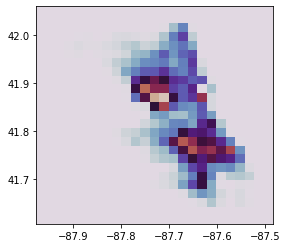

In [25]:
plt.imshow( X=np.rot90(density_matrix_t_series[-1]), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

In [26]:
density_matrix_t_series[0].shape

(25, 25)

In [ ]:
#This shape is for LSTM model input
#normalized_matrices.shape

In [28]:
density_matrix_t_series = np.rollaxis(np.dstack(density_matrix_t_series),-1)
density_matrix_t_series.shape

(1011, 25, 25)

In [ ]:
iterable = [np.rot90(matrix) for matrix in data2]

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('ggplot')
mpl.rcParams['agg.path.chunksize'] = 10000

df = map_arr[-1]
xdata = df["longitude"].dropna().to_numpy()
ydata = df["latitude"].dropna().to_numpy()
xlim=(min(xdata), max(xdata)) 
ylim=(min(ydata), max(ydata))

print(xlim)
print(ylim)

plt.rcParams["figure.figsize"] = [30, 30]
fig1, ax1 = plt.subplots()
#ax1.scatter(x="LONGITUDE", y="LATITUDE", data=map_arr[frame_from_latest], c="red", alpha=0.4)
im = plt.imshow( X=iterable[0], cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])


# initialization function 
def init(): 
    # creating an empty plot/frame
    # print("in init")
    im.set_data(iterable[0])
    return [im]


# animation function 
def animate(i):
    #df = map_arr[i]
    #xdata = df["LONGITUDE"].dropna().to_numpy()
    #ydata = df["LATITUDE"].dropna().to_numpy()
    #np.rot90(data2[i])
    #print("in animate")
    im.set_data(iterable[i])
    return [im]

# setting a title for the plot 
plt.title('Time series crime map with matplotlib!') 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig1, animate, init_func=init,frames=np.arange(0,np.rot90(data2).shape[1],1), interval=100, blit=True,repeat=False) 

# save the animation as mp4 video file 
anim.save(CSV_PATH + 'crime_zone.gif', writer='imagemagick') 
plt.show()

(-87.925269164, -87.524618154)
(41.651223603000005, 42.022534793)


In [29]:
import pickle
pickle.dump( density_matrix_t_series, open( CSV_PATH + "density_matrix_t_series_25x25.pickle", "wb" ) )